In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
!pip install xgboost

In [13]:
import pandas as pd
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score,recall_score
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from math import log, sqrt
%matplotlib inline 

In [14]:
credit_df = pd.read_csv("/content/drive/MyDrive/DataSets/creditcard.csv")

In [15]:
credit_df.describe().round(2)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00,284807.00
mean,94813.86,0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,88.35,0.00
std,47488.15,1.96,1.65,1.52,1.42,1.38,1.33,1.24,1.19,1.10,1.09,1.02,1.00,1.00,0.96,0.92,0.88,0.85,0.84,0.81,0.77,0.73,0.73,0.62,0.61,0.52,0.48,0.40,0.33,250.12,0.04
min,0.00,-56.41,-72.72,-48.33,-5.68,-113.74,-26.16,-43.56,-73.22,-13.43,-24.59,-4.80,-18.68,-5.79,-19.21,-4.50,-14.13,-25.16,-9.50,-7.21,-54.50,-34.83,-10.93,-44.81,-2.84,-10.30,-2.60,-22.57,-15.43,0.00,0.00
25%,54201.50,-0.92,-0.60,-0.89,-0.85,-0.69,-0.77,-0.55,-0.21,-0.64,-0.54,-0.76,-0.41,-0.65,-0.43,-0.58,-0.47,-0.48,-0.50,-0.46,-0.21,-0.23,-0.54,-0.16,-0.35,-0.32,-0.33,-0.07,-0.05,5.60,0.00
50%,84692.00,0.02,0.07,0.18,-0.02,-0.05,-0.27,0.04,0.02,-0.05,-0.09,-0.03,0.14,-0.01,0.05,0.05,0.07,-0.07,-0.00,0.00,-0.06,-0.03,0.01,-0.01,0.04,0.02,-0.05,0.00,0.01,22.00,0.00
75%,139320.50,1.32,0.80,1.03,0.74,0.61,0.40,0.57,0.33,0.60,0.45,0.74,0.62,0.66,0.49,0.65,0.52,0.40,0.50,0.46,0.13,0.19,0.53,0.15,0.44,0.35,0.24,0.09,0.08,77.16,0.00
max,172792.00,2.45,22.06,9.38,16.88,34.80,73.30,120.59,20.01,15.59,23.75,12.02,7.85,7.13,10.53,8.88,17.32,9.25,5.04,5.59,39.42,27.20,10.50,22.53,4.58,7.52,3.52,31.61,33.85,25691.16,1.00


# Class Imbalance
### Notice the ratio of fraudulent to non-fraudulent transaction

In [16]:
credit_df["Class"].value_counts()

0    284315
1       492
Name: Class, dtype: int64

In [17]:
credit_df["Class"].value_counts(normalize=True)

0    0.998273
1    0.001727
Name: Class, dtype: float64

# Random Undersampling
To resolve class imbalance , we will use the technique of random undersampling. This will ensure we have equal number of data samples from each label to train the model


# Steps to do undersampling based modeling

###1) Preserve the original values

###2) Scale all values if necessary

###3) If minority class values are too less, you'll have to do cross validation. Make sure you are also performing stratified sampling to maintain the original ratio of minority to majority classes.
###4) Divide original data into training and testing set. Verify if split is stratified
###5)  Now , sample the datset to ensure samples from all classes are equal in number
###6) Train the model on undersampled data
###7) Test the model on original values

In [18]:
from sklearn.model_selection import train_test_split

#Separate features and labels
X = credit_df.drop('Class', axis=1)
y = credit_df['Class']
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X,y,stratify=y)

original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.99827251 0.00172749]
[0.99827252 0.00172748]


In [19]:
  # Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

credit_df = credit_df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_credit_df = credit_df.loc[credit_df['Class'] == 1]
non_fraud_credit_df = credit_df.loc[credit_df['Class'] == 0][:492]

normal_distributed_credit_df = pd.concat([fraud_credit_df, non_fraud_credit_df])

# Shuffle dataframe rows
new_credit_df = normal_distributed_credit_df.sample(frac=1, random_state=42)

new_credit_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
8627,11650.0,-1.632329,1.842518,2.657462,0.640792,0.237113,0.411835,0.613857,-2.677508,2.462120,1.837891,1.782939,-2.078721,2.725942,-0.079082,1.082643,-0.830739,0.291485,-0.339479,-0.477342,0.503926,1.060751,-0.458138,-0.014265,0.298393,0.218421,-0.543628,-0.567761,-0.813954,10.00,0
249963,154657.0,-0.679521,4.672553,-6.814798,7.143500,0.928654,-1.873013,-2.306689,0.993702,-4.944054,-5.576419,5.783654,-6.117704,0.614165,-12.451499,0.427152,-2.255854,-2.128027,0.706765,1.093826,0.872006,0.566849,-0.321691,-0.281325,-1.120256,-0.073394,0.553530,0.760542,0.386742,0.77,1
188276,127899.0,2.100563,-0.707363,-1.175133,-0.751382,-0.605782,-0.398639,-1.029384,0.058659,-0.225570,0.241193,1.392186,-0.046240,0.203876,-1.942436,-0.339714,1.871824,1.108779,0.054154,0.487817,0.079625,0.289454,0.856235,0.129602,0.667618,-0.163149,-0.144249,0.020715,-0.013606,19.95,0
30314,35866.0,-2.044489,3.368306,-3.937111,5.623120,-3.079232,-1.253474,-5.778880,1.707428,-4.467103,-6.067798,3.839788,-8.277841,1.493915,-8.416681,0.792298,-7.862659,-14.570837,-5.185386,2.414390,1.112028,1.483594,0.834311,-0.148486,0.001669,-0.038996,0.389526,1.300236,0.549940,7.61,1
234574,148028.0,-1.053840,4.362801,-6.023534,5.304534,1.480738,-2.193821,-1.530817,0.626857,-4.037021,-6.285424,3.536145,-7.959628,-1.673429,-12.457999,-0.213885,-1.424131,-3.243686,0.059956,-1.802332,0.531574,0.397954,-0.945402,-0.376138,-0.220480,0.264003,0.048935,0.847220,0.531932,0.00,1


#  
#  Build a Gradient Boosting Model
###  

In this section we'll do k-fold cross validation and use gradient boosting for the prediction algorithm.We'll build our own cross validation loop for gradient boosting.  

In [20]:
# break into features and labels
# break into features and labels
xy_array = new_credit_df.values
x_array = xy_array[:,0:-1]
y_array = xy_array[:, -1]
print(x_array.shape, y_array.shape) #check the shape to see if it makes sense


x_train,x_test,y_train,y_test = train_test_split(x_array,y_array,test_size=0.1,stratify=y_array)

skf = StratifiedKFold(n_splits=10) #use StratifiedKFold package to define data splits for fold
skf.get_n_splits(x_train, y_train)

print(skf)




(984, 30) (984,)
StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [21]:
params = {'max_depth': 6,
         'n_estimators': 500,
         'learning_rate': 0.07,
         'objective': 'binary:logistic',
         'eval_metric': 'error',
         'alpha': 5,
         'nthread': 5,
         'verbosity': 1}

         
results_list = []
for train_index, val_index in skf.split(x_train, y_train):
    x_tr, x_val = x_train[train_index, :], x_train[val_index, :]
    #print(x_tr.shape)
    y_tr, y_val = y_train[train_index], y_train[val_index]
    # xgb_dmat = xgb.DMatrix(x_tr, label=y_tr)
    #print(1)
    model = xgb.XGBClassifier(**params, use_label_encoder=False)
    model.fit(x_tr, y_tr, eval_set=[(x_tr, y_tr), (x_val, y_val)],eval_metric='error', verbose=False)
    results = model.evals_result()
    results_list.append(results)

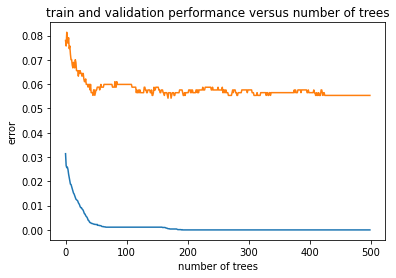

In [22]:
tr_avg = [sum([results_list[j]['validation_0']['error'][i] for j in range(10)])/10 for 
          i in range(len(results_list[0]['validation_0']['error']))]

val_avg = [sum([results_list[j]['validation_1']['error'][i] for j in range(10)])/10 for 
          i in range(len(results_list[0]['validation_1']['error']))]

plt.plot(tr_avg)
plt.plot(val_avg)
plt.title('train and validation performance versus number of trees')
plt.xlabel('number of trees')
plt.ylabel('error')
plt.show()

In [23]:
te_probs_gbm = model.predict_proba(original_Xtest)
prob1 = [x[1] for x in te_probs_gbm] #linear model returns prob of both binary outcomes

#threshold at 0.5
y_te_05 = [int(x + 0.5) for x in prob1]
y_te_75 = [int(x + 0.25) for x in prob1]
y_te_25 = [int(x + 0.75) for x in prob1]

conf_mat05 = confusion_matrix(original_ytest, y_te_05)
conf_mat75 = confusion_matrix(original_ytest, y_te_75)
conf_mat25 = confusion_matrix(original_ytest, y_te_25)

print('confusion matrix with 0.5 threshold \n', conf_mat05)
print('confusion matrix with 0.75 threshold \n', conf_mat75)
print('confusion matrix with 0.25 threshold \n', conf_mat25)

confusion matrix with 0.5 threshold 
 [[68645  2434]
 [    2   121]]
confusion matrix with 0.75 threshold 
 [[69643  1436]
 [    2   121]]
confusion matrix with 0.25 threshold 
 [[66988  4091]
 [    1   122]]


In [24]:
predicted_y = model.predict(x_test)
print(precision_score(predicted_y, y_test))
print(recall_score(predicted_y, y_test))


0.82
0.9534883720930233


##  
##  Feature importance

The dataframe below shows numerical values indicating which variable xgboost relied upon most heavily in making predictions of heart attach.  The list below shows them in order of most important to least.  

1. defect severity (thal, 0.271)
2. chest pain (cp, 0.228)
3. slope of the exercise ST segment (slope, 0.149)
4. number of major vessels colored in flouroscopy (ca, 0.145)
5. degree of exercise induced angina (exang, 0.111)

The rest of the variables are an order of magnitude less important.  Compare these to what penalized linear regression ranked at the most important features.  You'll see that there is agreement between the two lists for several of the variables.  One exception is thalach, which penalized regression relied upon, but gradient boosting ignored.  


In [25]:
columns = new_credit_df.columns

feature_importance_df = pd.DataFrame.from_dict(dict(zip(columns, model.feature_importances_)), orient='index')
display(feature_importance_df)

,0
Time,0.014000
V1,0.028343
V2,0.006067
V3,0.008095
V4,0.040648
V5,0.010212
V6,0.021633
V7,0.021586
V8,0.012951
V9,0.015690
